# Emulators: Measuring performance

This example illustrates how different neural networks perform in emulating the log-likelihood surface of a time series and in Bayesian inference, using a two-step MCMC procedure with emulator neural networks [Emulated Metropolis MCMC](../sampling/first-example.ipynb).

It follows on from [Emulators: First example](../mcmc/first-example-emulator.ipynb)

Like in the first example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [0.75, 1.0] # rescaled true parameters

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("Gaussian noise:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)
values = org_values + np.random.normal(0, noise, org_values.shape)

Gaussian noise: 24.898095903089327


Using matplotlib and seaborn (optional - for styling), I look at the noisy time series I just simulated:

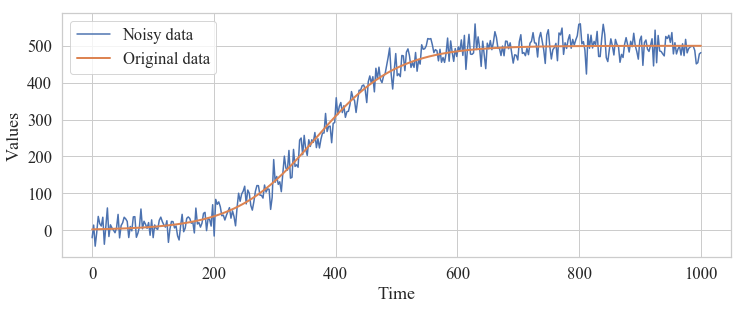

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Original data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create (rescaled) bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.5, 0.8], [1.0, 1.2])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions, using the rescaled true parameters:

In [12]:
xs = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [13]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0          0:00.9
2     9      0         0.333     0          0:00.9
3     12     0.25      0.25      0.25       0:00.9
20    63     0.19      0.143     0.238      0:01.0
40    123    0.0976    0.0732    0.146      0:01.0
60    183    0.082     0.0492    0.0984     0:01.0
80    243    0.0617    0.037     0.0741     0:01.0
100   303    0.0594    0.0297    0.0594     0:01.0
120   363    0.0496    0.0248    0.0579     0:01.0
140   423    0.0496    0.0213    0.0567     0:01.0
160   483    0.0435    0.0186    0.0559     0:01.1
180   543    0.0442    0.0166    0.0497     0:01.1
Initial phase completed.
200   603    0.039801  0.0149    0.0448     0:01.1
220   663    0.0679    0.0362    0.0769     0:01.1
240   723    0.104     0.0913    0.108      0:01.1
260   783   

3140  9423   0.226     0.220312  0.228      0:03.6
3160  9483   0.226     0.221     0.228      0:03.6
3180  9543   0.225     0.222     0.228      0:03.6
3200  9603   0.225     0.222     0.228      0:03.7
3220  9663   0.225     0.222     0.227      0:03.7
3240  9723   0.226     0.222     0.226      0:03.7
3260  9783   0.227     0.223     0.226      0:03.7
3280  9843   0.227     0.224     0.227      0:03.7
3300  9903   0.226598  0.225     0.227      0:03.7
3320  9963   0.226     0.226     0.22704    0:03.8
3340  10023  0.224783  0.226     0.228      0:03.8
3360  10083  0.225     0.226     0.228      0:03.8
3380  10143  0.224194  0.226856  0.228039   0:03.8
3400  10203  0.224     0.226698  0.228      0:03.8
3420  10263  0.225     0.226     0.227      0:03.9
3440  10323  0.225     0.226     0.227      0:03.9
3460  10383  0.226     0.226     0.227102   0:03.9
3480  10443  0.226     0.226     0.227      0:03.9
3500  10503  0.227     0.226     0.228      0:03.9
3520  10563  0.227     0.225   

6560  19683  0.23      0.227     0.228      0:06.6
6580  19743  0.229     0.227     0.229      0:06.6
6600  19803  0.229     0.227     0.228      0:06.6
6620  19863  0.229     0.227005  0.228      0:06.7
6640  19923  0.22858   0.227     0.228      0:06.7
6660  19983  0.228194  0.227     0.228      0:06.7
6680  20043  0.228     0.226     0.228      0:06.7
6700  20103  0.228     0.227     0.228      0:06.7
6720  20163  0.229     0.227     0.228      0:06.7
6740  20223  0.228     0.227     0.228      0:06.8
6760  20283  0.228     0.226     0.227777   0:06.8
6780  20343  0.228     0.227     0.227695   0:06.8
6800  20403  0.229     0.227     0.227      0:06.8
6820  20463  0.229     0.227     0.227      0:06.8
6840  20523  0.228     0.226     0.227      0:06.8
6860  20583  0.228     0.226     0.227      0:06.9
6880  20643  0.229     0.226     0.226      0:06.9
6900  20703  0.229     0.226     0.226      0:06.9
6920  20763  0.228     0.225401  0.227      0:06.9
6940  20823  0.228     0.225   

9940  29823  0.228     0.228     0.229      0:09.2
9960  29883  0.228     0.228     0.228      0:09.2
9980  29943  0.228     0.229     0.228434   0:09.3
10000 30000  0.2283    0.2287    0.2286     0:09.3
Halting: Maximum number of iterations (10000) reached.


To plot the parameter distributions on the original scale, I rescale the obtained Markov chains.

In [14]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_rescaled = np.copy(chains)
chain_rescaled = chains_rescaled[0]
chain_rescaled = chain_rescaled[2000:]

chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains])

## Using Pints' diagnostic plots to inspect the results

I then take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, I use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution and check out the resulting sample histograms.

In [15]:
colors = sns.choose_colorbrewer_palette(data_type='sequential', as_cmap=False)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

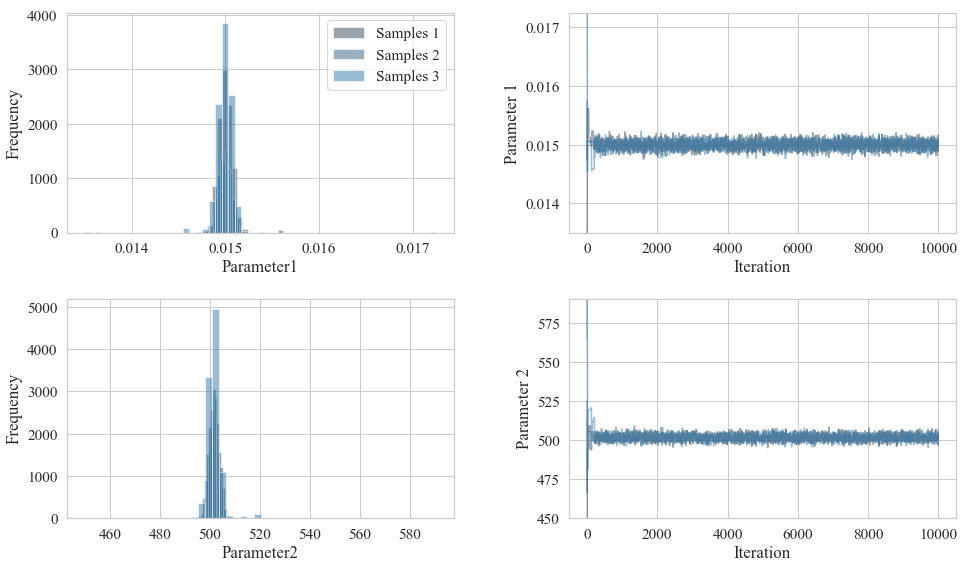

In [16]:
import pints.plot
    
#my_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
#my_colors = sns.color_palette("Blues_d", 3)
#my_colors = "Blues_d"
#my_colors = sns.xkcd_palette(["navy", "steel blue", "light blue"])
#my_colors = sns.color_palette('muted', n_colors=3)
sns.set(context='notebook', style='whitegrid', palette="Blues_d", font='Times New Roman',
        font_scale=1.4, color_codes=False, rc={"grid.linewidth": 1})
fig,ax  = pints.plot.trace(chains)
fig.set_size_inches(14, 10)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()
fig.savefig("figures/trace.png", bbox_inches='tight', dpi=600)

Based on this plot, it looks like the three chains become very similar after about 100 iterations.
To be safe, I throw away the first 2000 samples and continue the analysis with the first chain.

In [17]:
chain = chains[0]
chain = chain[2000:]

I also check for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

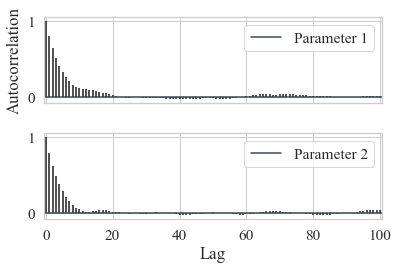

In [18]:
pints.plot.autocorrelation(chain)
plt.show()

Then, I inspect the inferred parameter distribution by plotting histograms:

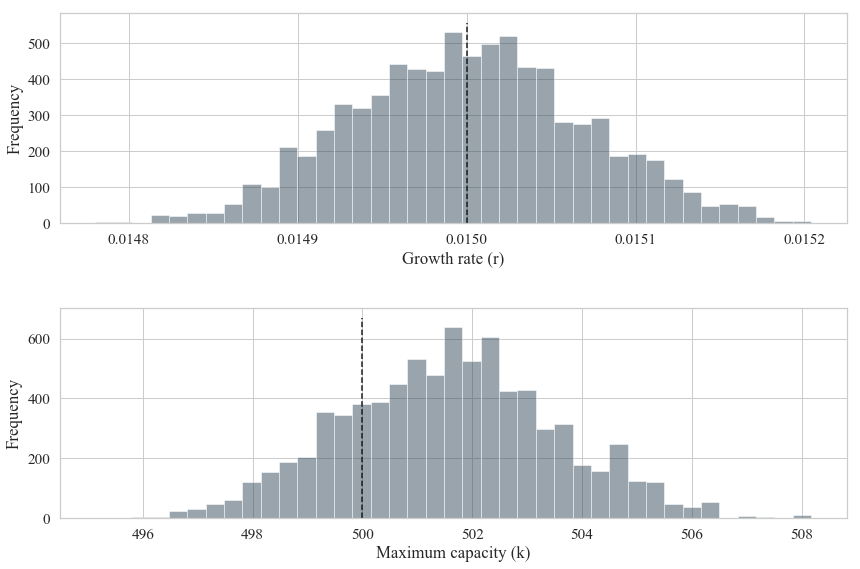

In [19]:
sns.set(context='notebook', style='whitegrid', palette='Blues_d', font='Times New Roman', 
        font_scale=1.4, color_codes=True, rc={"grid.linewidth": 1})
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters, 
                                 parameter_names=["Growth rate (r)", "Maximum capacity (k)"])
fig.set_size_inches(14, 10)
plt.subplots_adjust(wspace=0, hspace=0.4)
plt.show()

Here, each parameter is analyzed in isolation, but we can also look at correlations between parameters using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, I'll apply some _thinning_ to the chain:

In [20]:
thinned_chain = chain[::10]

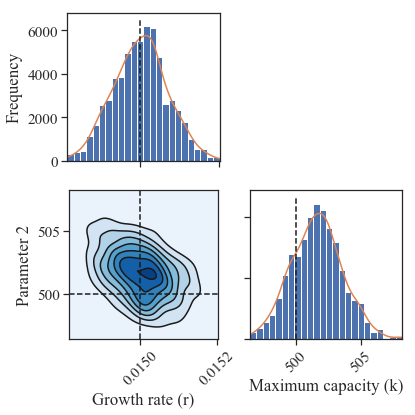

In [21]:
sns.set(context='notebook', style='ticks', palette='deep', font='Times New Roman', 
        font_scale=1.4, color_codes=True, rc={"grid.linewidth": 1})
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters, 
                    parameter_names=["Growth rate (r)", "Maximum capacity (k)"])
plt.show()

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

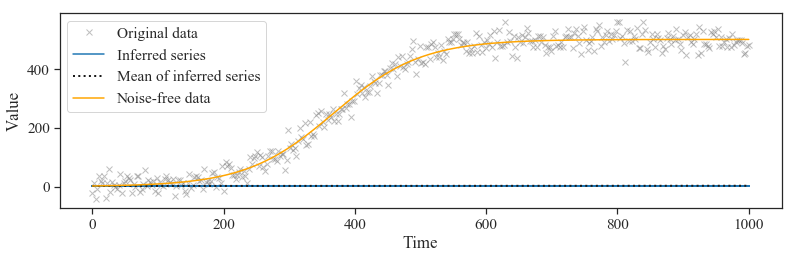

In [22]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

-1864.8359216823026
[0.7454858  1.00324495]
-47231.0423833991


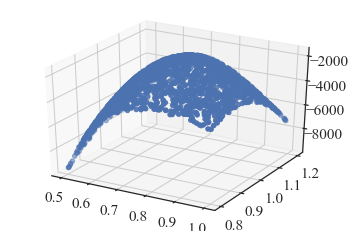

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

print(max(likelihoods))
idx = list(likelihoods).index(max(likelihoods))
print(input_parameters[idx])
print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [24]:
print(input_parameters[:5])

[[0.97393856 0.81643232]
 [0.60410618 1.00248707]
 [0.85441647 0.98664578]
 [0.93689975 0.92104924]
 [0.57308684 0.89748119]]


In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 82,753
Trainable params: 82,753
Non-trainable params: 0
_________________________________________________________________


In [26]:
emu([0.015, 500])

array([[-5933963.]], dtype=float32)

In [27]:
log_likelihood([0.015, 500])

-47231.0423833991

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'rescaled_mae', 'rescaled_mse', 'val_rescaled_mae', 'val_rescaled_mse'])


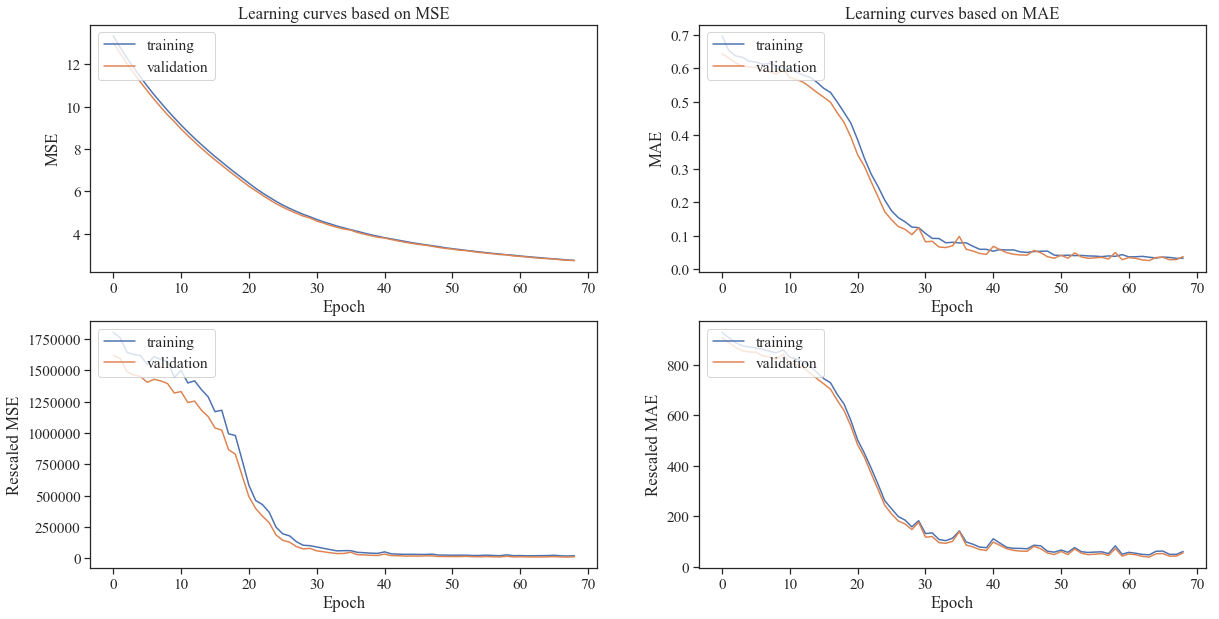

In [28]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

ax3.plot(hist.history['rescaled_mse'])
ax3.plot(hist.history['val_rescaled_mse'])
ax3.set_ylabel('Rescaled MSE')
ax3.set_xlabel('Epoch')
ax3.legend(['training', 'validation'], loc='upper left')

ax4.plot(hist.history['rescaled_mae'])
ax4.plot(hist.history['val_rescaled_mae'])
ax4.set_ylabel('Rescaled MAE')
ax4.set_xlabel('Epoch')
ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

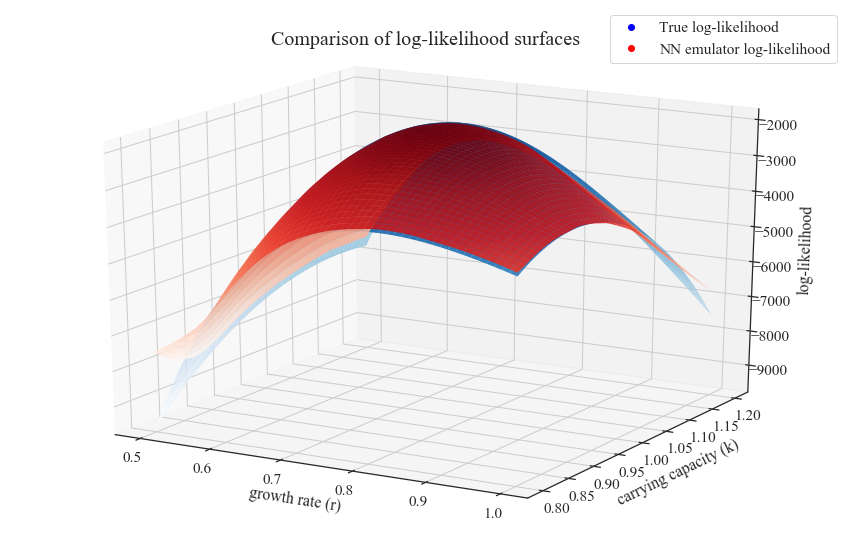

0.015336311236460586

In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D 

test_splits = 50 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)
emu_prediction = pints.predict_grid(emu, test_data)

figsize=(20,10)
angle=(20, 300)
alpha=0.9
fontsize=16
labelpad=10

title = "Comparison of log-likelihood surfaces"
x_label = "growth rate (r)"
y_label = "carrying capacity (k)"
z_label = "log-likelihood"


fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(r_grid, k_grid, model_prediction, cmap='Blues', edgecolor='none', alpha=alpha)
ax.plot_surface(r_grid, k_grid, emu_prediction, cmap='Reds', edgecolor='none', alpha=alpha)
#ax.view_init(60, 35)
ax.view_init(*angle)
#ax.set_title('surface')

plt.title(title, fontsize=fontsize*1.25)
ax.set_xlabel(x_label, fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel(y_label, fontsize=fontsize, labelpad=labelpad)
ax.set_zlabel(z_label, fontsize=fontsize, labelpad=labelpad)

fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
ax.legend([fake2Dline1, fake2Dline2], ["True log-likelihood", "NN emulator log-likelihood"])

plt.show()
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

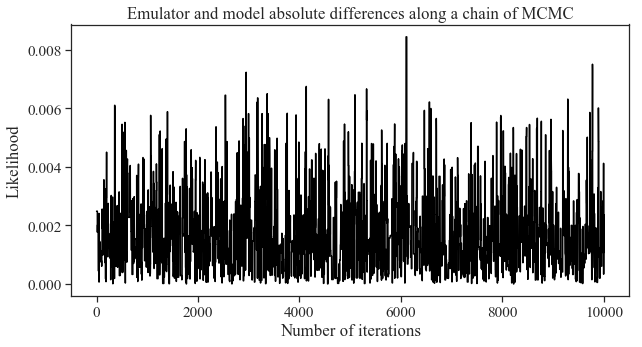

0.002368799131946256

In [30]:
emu_prediction = np.apply_along_axis(emu, 1, chain_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [31]:
print(emu_prediction)

[-1868.8845 -1868.8845 -1868.8845 ... -1863.4557 -1863.4557 -1870.4485]


In [32]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [33]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0.5       0          0:00.0
2     9      0.333     0.667     0.333      0:00.0
3     12     0.25      0.5       0.25       0:00.0
20    63     0.0952    0.19      0.143      0:00.0
40    123    0.0488    0.122     0.0732     0:00.1
60    183    0.0492    0.082     0.0492     0:00.1
80    243    0.0494    0.0617    0.037      0:00.2
100   303    0.0396    0.0495    0.0297     0:00.2
120   363    0.0331    0.0413    0.0248     0:00.2
140   423    0.0284    0.0355    0.0213     0:00.3
160   483    0.0248    0.0311    0.0186     0:00.3
180   543    0.0221    0.0276    0.0166     0:00.4
Initial phase completed.
200   603    0.0199    0.0249    0.0149     0:00.4
220   663    0.0362    0.0362    0.0362     0:00.4
240   723    0.0705    0.0747    0.083      0:00.5
260   783   

3100  9303   0.227     0.222     0.223      0:06.7
3120  9363   0.228132  0.221083  0.222      0:06.7
3140  9423   0.229     0.222     0.222      0:06.7
3160  9483   0.229     0.222398  0.222398   0:06.8
3180  9543   0.229     0.223     0.223      0:06.8
3200  9603   0.228     0.222     0.223      0:06.9
3220  9663   0.228     0.222     0.223      0:06.9
3240  9723   0.226     0.221     0.223      0:07.0
3260  9783   0.226     0.221     0.223      0:07.0
3280  9843   0.226     0.221274  0.224      0:07.0
3300  9903   0.226     0.221     0.224      0:07.1
3320  9963   0.227     0.221     0.225      0:07.1
3340  10023  0.227     0.222     0.224783   0:07.2
3360  10083  0.226     0.222     0.224338   0:07.2
3380  10143  0.226856  0.222     0.225      0:07.2
3400  10203  0.227     0.222     0.224      0:07.3
3420  10263  0.228     0.222     0.225      0:07.3
3440  10323  0.227     0.223     0.226      0:07.4
3460  10383  0.227     0.223     0.225      0:07.4
3480  10443  0.226     0.223499

6380  19143  0.228     0.227     0.228      0:13.7
6400  19203  0.228     0.227152  0.228      0:13.7
6420  19263  0.228     0.226756  0.228      0:13.7
6440  19323  0.228     0.227     0.228      0:13.8
6460  19383  0.228     0.227     0.228      0:13.8
6480  19443  0.229     0.227434  0.228      0:13.9
6500  19503  0.229     0.228     0.228      0:13.9
6520  19563  0.229     0.228     0.228      0:13.9
6540  19623  0.229     0.227641  0.229      0:14.0
6560  19683  0.229     0.228     0.229      0:14.0
6580  19743  0.229     0.228     0.229      0:14.1
6600  19803  0.229     0.229     0.229      0:14.1
6620  19863  0.229     0.229     0.229      0:14.2
6640  19923  0.229     0.22858   0.229      0:14.2
6660  19983  0.229     0.228     0.229      0:14.2
6680  20043  0.229307  0.228     0.229      0:14.3
6700  20103  0.229     0.228     0.229518   0:14.3
6720  20163  0.229     0.229     0.23       0:14.4
6740  20223  0.229     0.229     0.23       0:14.4
6760  20283  0.229     0.229   

9680  29043  0.23      0.23      0.229      0:20.7
9700  29103  0.23      0.229     0.23       0:20.8
9720  29163  0.23      0.229     0.23       0:20.8
9740  29223  0.23      0.229     0.23       0:20.9
9760  29283  0.23      0.229     0.23       0:20.9
9780  29343  0.23      0.229     0.23       0:21.0
9800  29403  0.23      0.229     0.23       0:21.0
9820  29463  0.23      0.22961   0.23       0:21.1
9840  29523  0.23      0.229     0.23       0:21.1
9860  29583  0.23      0.23      0.23       0:21.1
9880  29643  0.231     0.23      0.23       0:21.2
9900  29703  0.231     0.23      0.231      0:21.2
9920  29763  0.231     0.23      0.23       0:21.3
9940  29823  0.231     0.23      0.23       0:21.3
9960  29883  0.231     0.23      0.23       0:21.4
9980  29943  0.232     0.23      0.23       0:21.4
10000 30000  0.2319    0.2301    0.2298     0:21.5
Halting: Maximum number of iterations (10000) reached.


In [34]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_emu_rescaled = np.copy(chains_emu)
chain_emu_rescaled = chains_emu_rescaled[0]
chain_emu_rescaled = chain_emu_rescaled[2000:]

chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])

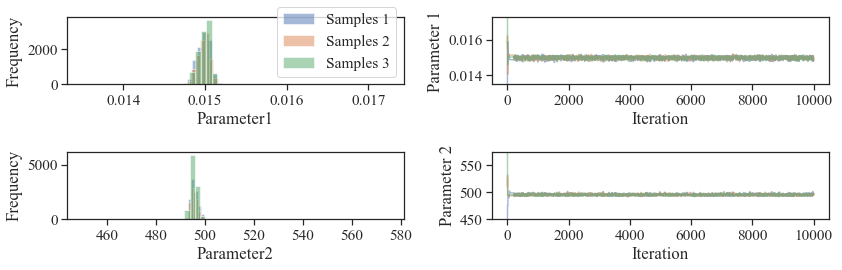

In [35]:
pints.plot.trace(chains_emu)
plt.show()

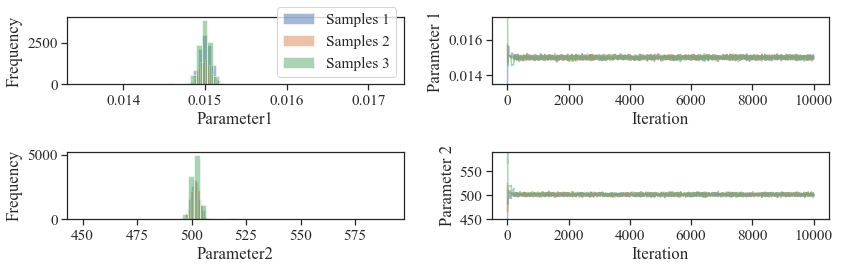

In [36]:
pints.plot.trace(chains)
plt.show()

In [37]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

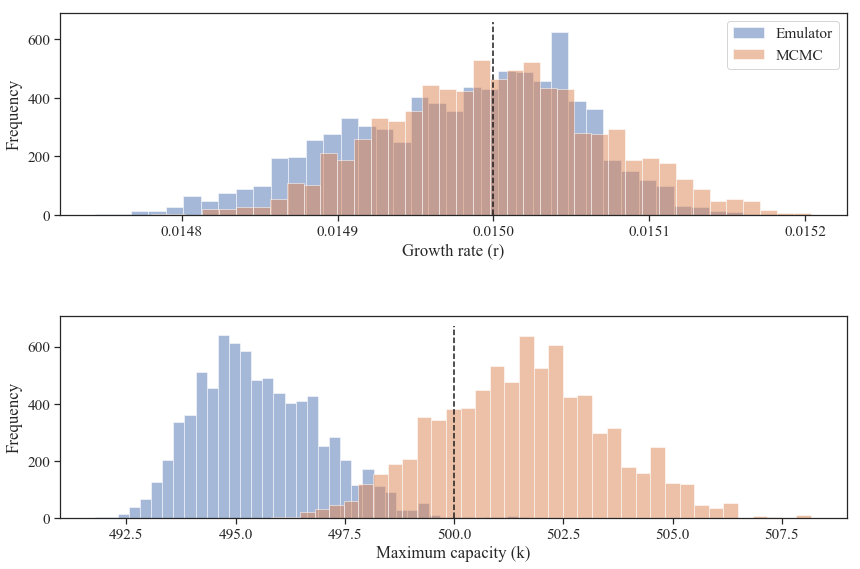

In [38]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, 
                                 parameter_names=["Growth rate (r)", "Maximum capacity (k)"],
                                 sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 10)
plt.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

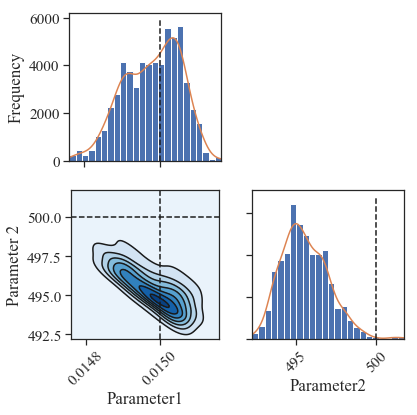

In [39]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

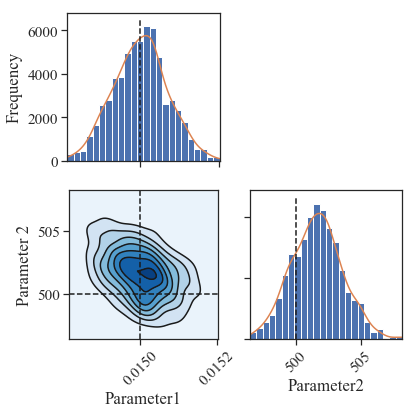

In [40]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

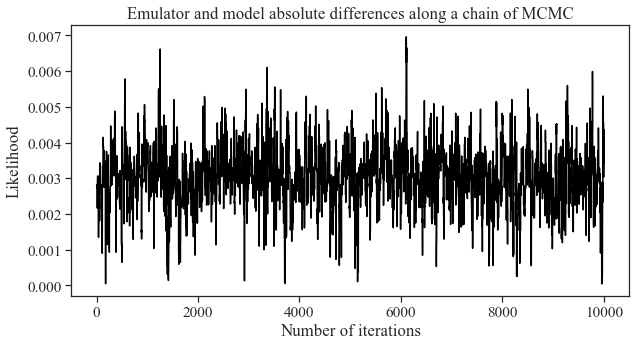

0.0034166966095541943

In [41]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_emu_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [42]:
chain_emu

array([[1.48767077e-02, 4.97046689e+02],
       [1.48767077e-02, 4.97046689e+02],
       [1.48767077e-02, 4.97046689e+02],
       ...,
       [1.48845728e-02, 4.97555439e+02],
       [1.48845728e-02, 4.97555439e+02],
       [1.48845728e-02, 4.97555439e+02]])

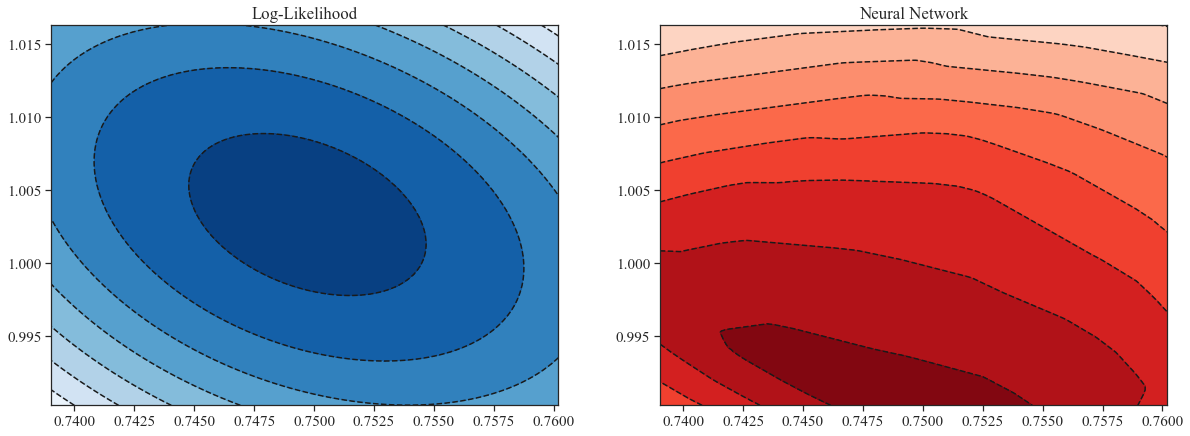

In [43]:
# Create grid of parameters
x = [p[0] for p in chain_rescaled]
y = [p[1] for p in chain_rescaled]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

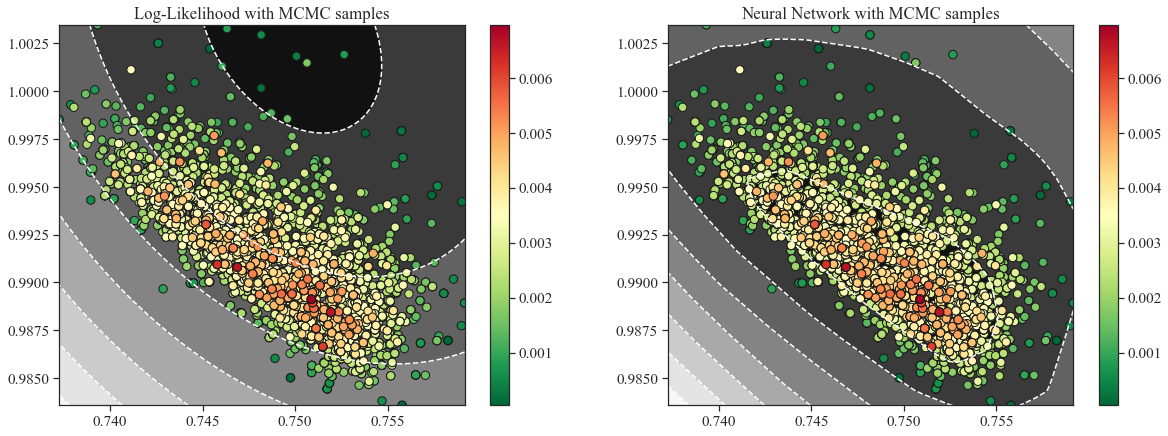

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu_rescaled]
y = [p[1] for p in chain_emu_rescaled]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0.5       0.5        0:00.0
2     9      0.333     0.333     0.333      0:00.0
3     12     0.25      0.25      0.5        0:00.0
20    63     0.19      0.19      0.238      0:00.0
40    123    0.0976    0.0976    0.171      0:00.0
60    183    0.0656    0.0656    0.115      0:00.0
80    243    0.0864    0.0494    0.0988     0:00.1
100   303    0.0693    0.0396    0.0891     0:00.1
120   363    0.0579    0.0331    0.0826     0:00.1
140   423    0.0496    0.0284    0.0709     0:00.1
160   483    0.0435    0.0248    0.0621     0:00.1
180   543    0.0387    0.0221    0.0552     0:00.1
Initial phase completed.
200   603    0.0348    0.0199    0.0498     0:00.1
220   663    0.0724    0.0362    0.0769     0:00.2
240   723    0.0913    0.0954    0.0954     0:00.2
2

3240  9723   0.23      0.221228  0.232      0:02.4
3260  9783   0.23      0.222     0.231      0:02.4
3280  9843   0.23      0.222     0.231      0:02.5
3300  9903   0.231     0.222     0.232      0:02.5
3320  9963   0.23      0.222     0.232      0:02.5
3340  10023  0.23      0.223     0.232      0:02.5
3360  10083  0.229396  0.222     0.231      0:02.5
3380  10143  0.230701  0.222     0.231      0:02.5
3400  10203  0.232     0.222     0.231      0:02.5
3420  10263  0.232     0.221865  0.231      0:02.6
3440  10323  0.232     0.222     0.23       0:02.6
3460  10383  0.231436  0.221     0.23       0:02.6
3480  10443  0.232     0.221     0.23       0:02.6
3500  10503  0.232505  0.221     0.231      0:02.6
3520  10563  0.232     0.221812  0.23       0:02.6
3540  10623  0.231573  0.222     0.230161   0:02.6
3560  10683  0.231     0.223     0.23       0:02.7
3580  10743  0.231     0.223     0.229      0:02.7
3600  10803  0.231     0.223     0.229      0:02.7
3620  10863  0.232     0.223   

6680  20043  0.228     0.226     0.225116   0:05.0
6700  20103  0.227     0.226     0.225041   0:05.0
6720  20163  0.226752  0.226008  0.225      0:05.1
6740  20223  0.227     0.226     0.225      0:05.1
6760  20283  0.227     0.22615   0.225      0:05.1
6780  20343  0.227     0.226     0.224      0:05.1
6800  20403  0.227     0.226     0.224      0:05.1
6820  20463  0.226     0.22592   0.224      0:05.1
6840  20523  0.227     0.226     0.224      0:05.1
6860  20583  0.227     0.226     0.225      0:05.2
6880  20643  0.227     0.226     0.225      0:05.2
6900  20703  0.227     0.226     0.22475    0:05.2
6920  20763  0.227     0.226     0.225      0:05.2
6940  20823  0.227     0.225904  0.224      0:05.2
6960  20883  0.227     0.226     0.224393   0:05.2
6980  20943  0.227     0.227     0.224      0:05.2
7000  21003  0.227     0.227     0.224      0:05.3
7020  21063  0.227     0.227     0.224327   0:05.3
7040  21123  0.227     0.227     0.224542   0:05.3
7060  21183  0.22688   0.227   

10120 30363  0.229424  0.230906  0.228      0:07.6
10140 30423  0.23      0.231     0.228084   0:07.6
10160 30483  0.23      0.230686  0.228      0:07.6
10180 30543  0.23      0.231     0.228      0:07.6
10200 30603  0.23      0.231     0.228      0:07.7
10220 30663  0.23      0.231     0.228      0:07.7
10240 30723  0.23      0.231     0.228      0:07.7
10260 30783  0.23      0.231     0.228      0:07.7
10280 30843  0.23      0.231     0.228      0:07.7
10300 30903  0.230366  0.231     0.228      0:07.7
10320 30963  0.230404  0.231     0.228      0:07.7
10340 31023  0.23      0.231     0.228      0:07.8
10360 31083  0.231     0.231     0.228      0:07.8
10380 31143  0.230421  0.231     0.228      0:07.8
10400 31203  0.23      0.231     0.228055   0:07.8
10420 31263  0.231     0.23088   0.229      0:07.8
10440 31323  0.231     0.230725  0.228      0:07.8
10460 31383  0.23      0.231     0.229      0:07.8
10480 31443  0.23      0.231     0.229      0:07.9
10500 31503  0.231     0.231   

13580 40743  0.231     0.229     0.23       0:10.2
13600 40803  0.231     0.229     0.23       0:10.2
13620 40863  0.231     0.229     0.229572   0:10.2
13640 40923  0.231     0.229     0.23       0:10.3
13660 40983  0.231     0.228     0.229      0:10.3
13680 41043  0.231562  0.228     0.229      0:10.3
13700 41103  0.23137   0.228     0.229      0:10.3
13720 41163  0.231     0.228     0.229      0:10.3
13740 41223  0.231     0.227931  0.229      0:10.3
13760 41283  0.231     0.228     0.229      0:10.3
13780 41343  0.231     0.228     0.229      0:10.4
13800 41403  0.231     0.227882  0.229      0:10.4
13820 41463  0.232     0.228     0.229      0:10.4
13840 41523  0.232     0.227657  0.229      0:10.4
13860 41583  0.232     0.228     0.22906    0:10.4
13880 41643  0.231     0.228     0.228802   0:10.4
13900 41703  0.231     0.228     0.229      0:10.5
13920 41763  0.231     0.228     0.229      0:10.5
13940 41823  0.231     0.228     0.229      0:10.5
13960 41883  0.231     0.228   

17040 51123  0.232     0.23      0.23       0:12.8
17060 51183  0.232     0.229881  0.229881   0:12.8
17080 51243  0.232     0.23      0.23       0:12.8
17100 51303  0.232     0.23      0.23       0:12.9
17120 51363  0.232     0.23      0.23       0:12.9
17140 51423  0.231     0.23      0.23       0:12.9
17160 51483  0.231     0.23      0.23       0:12.9
17180 51543  0.231     0.23      0.23       0:12.9
17200 51603  0.231     0.230161  0.23       0:12.9
17220 51663  0.231     0.23      0.23       0:13.0
17240 51723  0.231     0.23      0.23       0:13.0
17260 51783  0.231     0.23      0.23       0:13.0
17280 51843  0.231526  0.23      0.230195   0:13.0
17300 51903  0.231     0.23      0.23       0:13.0
17320 51963  0.232     0.23      0.23       0:13.0
17340 52023  0.232     0.23      0.23       0:13.0
17360 52083  0.232     0.23      0.23       0:13.1
17380 52143  0.232     0.23      0.23       0:13.1
17400 52203  0.232     0.229642  0.23       0:13.1
17420 52263  0.232     0.23    

20500 61503  0.233     0.232     0.23       0:15.5
20520 61563  0.233     0.232     0.23       0:15.5
20540 61623  0.233     0.232     0.23       0:15.5
20560 61683  0.233     0.232     0.23       0:15.5
20580 61743  0.233     0.232     0.23       0:15.5
20600 61803  0.233     0.232     0.23       0:15.5
20620 61863  0.233     0.232     0.23       0:15.6
20640 61923  0.234     0.232     0.23       0:15.6
20660 61983  0.234     0.232     0.23       0:15.6
20680 62043  0.234     0.232     0.23       0:15.6
20700 62103  0.234     0.232     0.231      0:15.6
20720 62163  0.234     0.232     0.231      0:15.6
20740 62223  0.234     0.232     0.230606   0:15.6
20760 62283  0.234     0.232     0.231      0:15.7
20780 62343  0.234     0.232     0.231      0:15.7
20800 62403  0.234     0.232     0.231      0:15.7
20820 62463  0.234     0.232     0.231      0:15.7
20840 62523  0.234     0.233     0.230939   0:15.7
20860 62583  0.234     0.233     0.231      0:15.7
20880 62643  0.234     0.233   

23940 71823  0.233     0.232     0.232      0:18.1
23960 71883  0.233     0.232     0.233      0:18.1
23980 71943  0.233     0.232     0.233      0:18.1
24000 72003  0.232532  0.232282  0.232532   0:18.1
24020 72063  0.232     0.232     0.233      0:18.1
24040 72123  0.232     0.232     0.232561   0:18.1
24060 72183  0.232     0.232     0.233      0:18.2
24080 72243  0.232     0.232     0.23259    0:18.2
24100 72303  0.232148  0.23248   0.233      0:18.2
24120 72363  0.232     0.233     0.232536   0:18.2
24140 72423  0.232     0.232799  0.232509   0:18.2
24160 72483  0.231944  0.233     0.232      0:18.2
24180 72543  0.232083  0.232662  0.232      0:18.2
24200 72603  0.232     0.233     0.233      0:18.3
24220 72663  0.232     0.233     0.233      0:18.3
24240 72723  0.232     0.233     0.233      0:18.3
24260 72783  0.232     0.233     0.233      0:18.3
24280 72843  0.232     0.233     0.233      0:18.3
24300 72903  0.232     0.233     0.233      0:18.3
24320 72963  0.232     0.233   

27400 82203  0.231     0.233     0.233      0:20.7
27420 82263  0.231392  0.233     0.233      0:20.7
27440 82323  0.231     0.233     0.233      0:20.7
27460 82383  0.231237  0.233     0.233      0:20.7
27480 82443  0.231     0.233     0.233      0:20.7
27500 82503  0.231     0.233     0.233      0:20.7
27520 82563  0.231     0.232804  0.233      0:20.7
27540 82623  0.231     0.233     0.233      0:20.8
27560 82683  0.231     0.232575  0.233      0:20.8
27580 82743  0.231     0.233     0.233      0:20.8
27600 82803  0.231     0.233     0.233      0:20.8
27620 82863  0.231     0.233     0.233      0:20.8
27640 82923  0.231     0.233     0.233      0:20.8
27660 82983  0.231     0.233     0.233      0:20.9
27680 83043  0.231     0.233     0.233      0:20.9
27700 83103  0.231     0.232     0.233      0:20.9
27720 83163  0.231     0.232     0.233      0:20.9
27740 83223  0.231138  0.232     0.233      0:20.9
27760 83283  0.231     0.232     0.233      0:20.9
27780 83343  0.231     0.232425

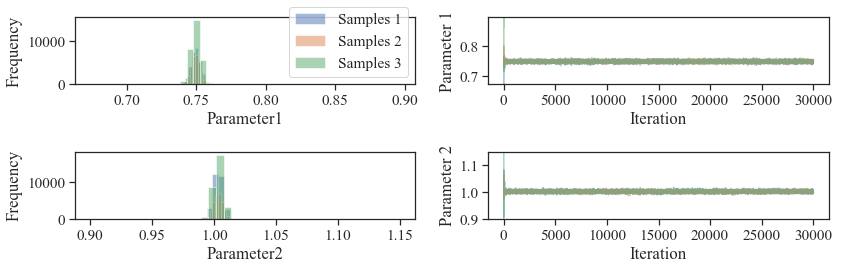

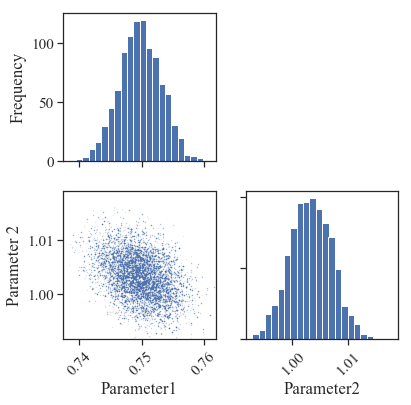

In [45]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = [0.01, 0.01] #np.abs(true_parameters) * 5e-5

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
mcmc.set_log_to_screen(True)

# Run!
print('Running...')
ac_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(ac_chains)

# Discard warm up
ac_chains_thinned = ac_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(ac_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(ac_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Emulated Metropolis MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0          0:00.0
2     9      0         0.333     0          0:00.0
3     12     0         0.25      0          0:00.0
20    63     0.143     0.19      0.238      0:00.1
40    123    0.122     0.146     0.171      0:00.1
60    183    0.0984    0.147541  0.115      0:00.1
80    243    0.0864    0.136     0.0988     0:00.2
100   303    0.129     0.119     0.099      0:00.2
120   363    0.198     0.107438  0.0826     0:00.3
140   423    0.184     0.106383  0.0709     0:00.3
160   483    0.173913  0.13      0.0621     0:00.4
180   543    0.166     0.138     0.0552     0:00.4
200   603    0.154     0.154     0.0547     0:00.5
220   663    0.145     0.14      0.0498     0:00.5
240   723    0.133     0.141     0.0498     0:00.6
260   783    0.134     0.142     0.046    

3160  9483   0.191     0.193     0.0168     0:07.4
3180  9543   0.191     0.193     0.0167     0:07.4
3200  9603   0.191     0.192     0.0166     0:07.5
3220  9663   0.191245  0.191245  0.0165     0:07.5
3240  9723   0.191     0.191     0.0164     0:07.6
3260  9783   0.19      0.191659  0.0166     0:07.6
3280  9843   0.19      0.192     0.0168     0:07.7
3300  9903   0.19      0.191     0.017      0:07.7
3320  9963   0.189     0.191     0.0172     0:07.7
3340  10023  0.189     0.192     0.0174     0:07.8
3360  10083  0.19      0.192     0.0173     0:07.8
3380  10143  0.189     0.193     0.0172     0:07.9
3400  10203  0.189     0.194     0.0171     0:07.9
3420  10263  0.189     0.195     0.0172     0:08.0
3440  10323  0.19      0.194     0.0171     0:08.0
3460  10383  0.19      0.194     0.017      0:08.1
3480  10443  0.189888  0.193     0.0172     0:08.1
3500  10503  0.189     0.193     0.0171     0:08.2
3520  10563  0.188     0.193411  0.017      0:08.2
3540  10623  0.19      0.193   

6420  19263  0.201     0.198     0.014      0:14.9
6440  19323  0.201211  0.199     0.0141     0:15.0
6460  19383  0.202     0.199     0.0141     0:15.0
6480  19443  0.202     0.199     0.0142     0:15.1
6500  19503  0.202     0.199     0.0142     0:15.1
6520  19563  0.202     0.199     0.0141     0:15.1
6540  19623  0.202     0.2       0.0141     0:15.2
6560  19683  0.203     0.199     0.014      0:15.2
6580  19743  0.202     0.199     0.014      0:15.3
6600  19803  0.202     0.199     0.0141     0:15.3
6620  19863  0.201     0.199     0.014      0:15.4
6640  19923  0.202     0.199     0.014      0:15.4
6660  19983  0.202     0.198769  0.014      0:15.5
6680  20043  0.203     0.198623  0.0141     0:15.5
6700  20103  0.203     0.199     0.014      0:15.5
6720  20163  0.202     0.198     0.0141     0:15.6
6740  20223  0.203     0.199     0.0145     0:15.6
6760  20283  0.202     0.199     0.0146     0:15.7
6780  20343  0.202625  0.199     0.0146     0:15.7
6800  20403  0.203     0.199   

9720  29163  0.201     0.201     0.0127     0:22.2
9740  29223  0.2       0.201     0.0126     0:22.3
9760  29283  0.200082  0.2       0.0126     0:22.3
9780  29343  0.2       0.200593  0.0126     0:22.3
9800  29403  0.2       0.201     0.0125     0:22.4
9820  29463  0.2       0.2       0.0125     0:22.4
9840  29523  0.2       0.2       0.0125     0:22.5
9860  29583  0.2       0.2       0.0125     0:22.5
9880  29643  0.2       0.200081  0.0124     0:22.6
9900  29703  0.2       0.2       0.0124     0:22.6
9920  29763  0.2       0.2       0.0124     0:22.6
9940  29823  0.2       0.199     0.012373   0:22.7
9960  29883  0.2       0.2       0.0123     0:22.7
9980  29943  0.2       0.199479  0.0124     0:22.8
10000 30003  0.20028   0.199     0.0124     0:22.8
10020 30063  0.2       0.199     0.0125     0:22.9
10040 30123  0.2       0.199     0.0124     0:22.9
10060 30183  0.2       0.2       0.0124     0:23.0
10080 30243  0.199881  0.2       0.0124     0:23.0
10100 30303  0.2       0.2     

13020 39063  0.2       0.205     0.0108     0:29.5
13040 39123  0.2       0.205     0.0108     0:29.5
13060 39183  0.2       0.205191  0.0108     0:29.5
13080 39243  0.2       0.205     0.0108     0:29.6
13100 39303  0.2       0.205     0.0108     0:29.6
13120 39363  0.2       0.206     0.0107     0:29.7
13140 39423  0.2       0.205     0.0107     0:29.7
13160 39483  0.2       0.205     0.0107     0:29.8
13180 39543  0.2       0.205     0.0107     0:29.8
13200 39603  0.2       0.206     0.0107     0:29.9
13220 39663  0.2       0.206     0.0107     0:29.9
13240 39723  0.2       0.206     0.0106     0:29.9
13260 39783  0.2       0.206     0.0106     0:30.0
13280 39843  0.2       0.206     0.0106     0:30.0
13300 39903  0.2       0.206     0.0107     0:30.1
13320 39963  0.2       0.206     0.0107     0:30.1
13340 40023  0.199985  0.206     0.0106     0:30.2
13360 40083  0.2       0.206     0.0106     0:30.2
13380 40143  0.2       0.206     0.0106     0:30.3
13400 40203  0.2       0.206   

16320 48963  0.199     0.206     0.00993    0:36.7
16340 49023  0.199     0.205679  0.00991    0:36.8
16360 49083  0.199     0.206     0.0099     0:36.8
16380 49143  0.199     0.206     0.00989    0:36.8
16400 49203  0.199     0.206     0.00994    0:36.9
16420 49263  0.199     0.205     0.00993    0:36.9
16440 49323  0.199258  0.206     0.00998    0:37.0
16460 49383  0.2       0.205     0.00996    0:37.0
16480 49443  0.199     0.206     0.01       0:37.1
16500 49503  0.2       0.206     0.01       0:37.1
16520 49563  0.2       0.206     0.00999    0:37.2
16540 49623  0.2       0.206     0.00998    0:37.2
16560 49683  0.2       0.206     0.00996    0:37.2
16580 49743  0.2       0.206     0.00995    0:37.3
16600 49803  0.2       0.206     0.00994    0:37.3
16620 49863  0.2       0.206     0.00999    0:37.4
16640 49923  0.199     0.206     0.00998    0:37.4
16660 49983  0.199     0.20599   0.00996    0:37.5
16680 50043  0.2       0.206     0.00995    0:37.5
16700 50103  0.199509  0.206   

19620 58863  0.2       0.208     0.0103     0:44.0
19640 58923  0.2       0.208136  0.0104     0:44.0
19660 58983  0.2       0.208     0.0105     0:44.1
19680 59043  0.2       0.208     0.0105     0:44.1
19700 59103  0.2       0.208     0.0106     0:44.1
19720 59163  0.2       0.208     0.0106     0:44.2
19740 59223  0.2       0.208     0.0107     0:44.2
19760 59283  0.2       0.208     0.0108     0:44.3
19780 59343  0.2       0.208     0.0108     0:44.3
19800 59403  0.2       0.208     0.0109     0:44.4
19820 59463  0.2       0.208     0.0109     0:44.4
19840 59523  0.2       0.209     0.0109     0:44.4
19860 59583  0.2       0.209     0.0109     0:44.5
19880 59643  0.2       0.208     0.0109     0:44.5
19900 59703  0.2       0.209     0.011      0:44.6
19920 59763  0.2       0.209     0.0109     0:44.6
19940 59823  0.19999   0.209     0.011      0:44.7
19960 59883  0.19999   0.209     0.011      0:44.7
19980 59943  0.2       0.208     0.011      0:44.8
20000 60003  0.20014   0.209   

22920 68763  0.197     0.209     0.018      0:51.2
22940 68823  0.197     0.209     0.018      0:51.3
22960 68883  0.197     0.209     0.0183     0:51.3
22980 68943  0.197511  0.209     0.0185     0:51.4
23000 69003  0.198     0.209     0.0186     0:51.4
23020 69063  0.198     0.209     0.0187     0:51.4
23040 69123  0.198     0.209     0.0189     0:51.5
23060 69183  0.198     0.209     0.019      0:51.5
23080 69243  0.198     0.21      0.0195     0:51.6
23100 69303  0.198     0.21      0.0197     0:51.6
23120 69363  0.198     0.21      0.0201     0:51.7
23140 69423  0.198     0.21      0.0202     0:51.7
23160 69483  0.198     0.209706  0.0204     0:51.8
23180 69543  0.198     0.21      0.0204     0:51.8
23200 69603  0.197707  0.21      0.0206     0:51.8
23220 69663  0.198     0.21      0.0207     0:51.9
23240 69723  0.198     0.21      0.0208     0:51.9
23260 69783  0.198     0.21      0.021      0:52.0
23280 69843  0.198     0.21      0.0211     0:52.0
23300 69903  0.198     0.21    

26220 78663  0.196     0.208     0.0432     0:58.5
26240 78723  0.195991  0.208     0.0433     0:58.5
26260 78783  0.195956  0.208     0.0434     0:58.6
26280 78843  0.196     0.208     0.0435     0:58.6
26300 78903  0.195734  0.208     0.0436     0:58.7
26320 78963  0.196     0.208     0.0438     0:58.7
26340 79023  0.196     0.208     0.044      0:58.8
26360 79083  0.195     0.208     0.0441     0:58.8
26380 79143  0.195     0.208     0.0443     0:58.9
26400 79203  0.195     0.208     0.0445     0:58.9
26420 79263  0.195     0.208     0.0447     0:58.9
26440 79323  0.195     0.208     0.0449     0:59.0
26460 79383  0.195     0.208     0.045      0:59.0
26480 79443  0.195     0.208     0.0451     0:59.1
26500 79503  0.196     0.208294  0.0453     0:59.1
26520 79563  0.196     0.208     0.0455     0:59.2
26540 79623  0.196     0.208     0.0457     0:59.2
26560 79683  0.196     0.208     0.0457     0:59.3
26580 79743  0.195478  0.208     0.0457     0:59.3
26600 79803  0.195     0.208   

29520 88563  0.197     0.208     0.062      1:05.8
29540 88623  0.198     0.208     0.062      1:05.8
29560 88683  0.198     0.208     0.0622     1:05.9
29580 88743  0.198     0.208     0.0622     1:05.9
29600 88803  0.198     0.208     0.0622     1:06.0
29620 88863  0.198     0.208     0.0623     1:06.0
29640 88923  0.198     0.208     0.0624     1:06.1
29660 88983  0.198     0.208     0.0624     1:06.1
29680 89043  0.198     0.208     0.0626     1:06.1
29700 89103  0.198     0.208     0.0626     1:06.2
29720 89163  0.198     0.208     0.0626     1:06.2
29740 89223  0.198     0.208     0.0628     1:06.3
29760 89283  0.198     0.208     0.063      1:06.3
29780 89343  0.198     0.208     0.063      1:06.4
29800 89403  0.198     0.208     0.0631     1:06.4
29820 89463  0.198     0.208     0.0631     1:06.4
29840 89523  0.198     0.209     0.0632     1:06.5
29860 89583  0.198051  0.209     0.0633     1:06.5
29880 89643  0.198     0.209     0.0635     1:06.6
29900 89703  0.198     0.209   

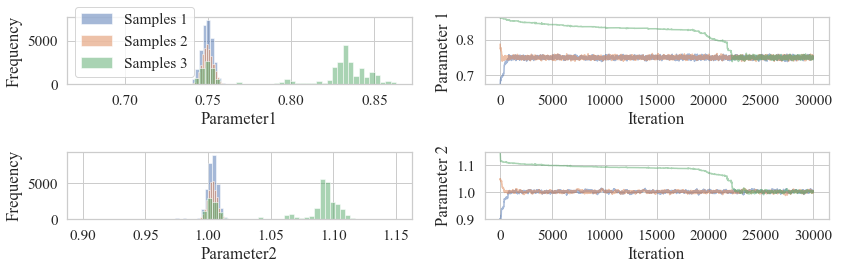

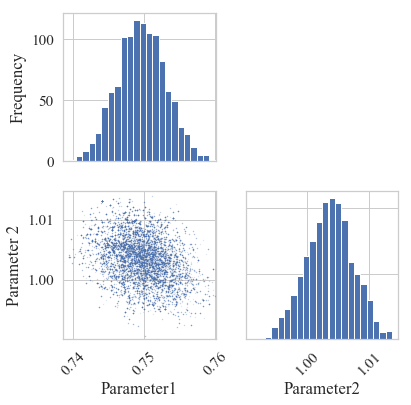

In [51]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
#sigma0 = [0.01, 0.01] #np.abs(true_parameters) * 5e-3
#sigma0 = [0.1*0.75, 0.1] #np.abs(true_parameters) * 5e-3
sigma0 = [[ 1.01547594e-05, -2.58358260e-06], [-2.58358260e-06,  1.22093040e-05]]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0.5        0:00.0
2     9      0         0.333     0.667      0:00.0
3     12     0         0.5       0.5        0:00.0
20    63     0.333     0.524     0.381      0:00.0
40    123    0.439     0.512     0.439      0:00.0
60    183    0.41      0.492     0.459      0:00.0
80    243    0.432     0.519     0.457      0:00.1
100   303    0.436     0.535     0.455      0:00.1
120   363    0.471     0.553719  0.488      0:00.1
140   423    0.532     0.567     0.475      0:00.1
160   483    0.515528  0.571     0.503      0:00.1
180   543    0.53      0.569     0.492      0:00.1
200   603    0.512     0.577     0.498      0:00.1
220   663    0.511     0.579     0.507      0:00.2
240   723    0.51      0.568     0.51       0:00.2
260   783    0.51      0.563     0.517 

3180  9543   0.561     0.561     0.551      0:02.2
3200  9603   0.56      0.562     0.551      0:02.2
3220  9663   0.561     0.563     0.551      0:02.3
3240  9723   0.560938  0.563     0.551      0:02.3
3260  9783   0.562     0.563     0.551058   0:02.3
3280  9843   0.561     0.564     0.551      0:02.3
3300  9903   0.563     0.563     0.552      0:02.3
3320  9963   0.563     0.563     0.553      0:02.3
3340  10023  0.562     0.563     0.553      0:02.3
3360  10083  0.562     0.564     0.553      0:02.4
3380  10143  0.562     0.563     0.552795   0:02.4
3400  10203  0.562     0.563     0.553      0:02.4
3420  10263  0.563     0.563     0.553      0:02.4
3440  10323  0.563499  0.563     0.552      0:02.4
3460  10383  0.565     0.563     0.552      0:02.4
3480  10443  0.564     0.562482  0.552      0:02.4
3500  10503  0.565     0.562982  0.552      0:02.5
3520  10563  0.566     0.562     0.552      0:02.5
3540  10623  0.565     0.562     0.553      0:02.5
3560  10683  0.566     0.562   

6600  19803  0.569     0.563854  0.561      0:04.6
6620  19863  0.569     0.563359  0.561      0:04.7
6640  19923  0.569     0.564     0.561      0:04.7
6660  19983  0.569     0.564     0.561      0:04.7
6680  20043  0.569     0.564     0.561      0:04.7
6700  20103  0.569     0.564     0.561      0:04.7
6720  20163  0.568963  0.564     0.561226   0:04.7
6740  20223  0.569     0.564     0.561      0:04.7
6760  20283  0.569     0.564     0.561      0:04.8
6780  20343  0.569     0.563     0.561      0:04.8
6800  20403  0.569034  0.563     0.561      0:04.8
6820  20463  0.569     0.562     0.561      0:04.8
6840  20523  0.568338  0.562     0.561      0:04.8
6860  20583  0.568     0.562     0.561      0:04.8
6880  20643  0.568522  0.562     0.562      0:04.8
6900  20703  0.569048  0.562     0.562      0:04.9
6920  20763  0.569     0.562     0.562      0:04.9
6940  20823  0.569     0.562     0.562599   0:04.9
6960  20883  0.568     0.562     0.563      0:04.9
6980  20943  0.568     0.562   

9940  29823  0.572     0.561     0.562      0:07.0
9960  29883  0.571     0.561     0.562      0:07.0
9980  29943  0.571     0.561066  0.563      0:07.0
10000 30003  0.572     0.561     0.563      0:07.0
10020 30063  0.571899  0.561     0.563      0:07.0
10040 30123  0.572     0.561     0.563      0:07.1
10060 30183  0.572     0.561     0.563      0:07.1
10080 30243  0.572     0.561     0.563      0:07.1
10100 30303  0.572     0.561     0.563      0:07.1
10120 30363  0.572     0.561     0.562889   0:07.1
10140 30423  0.572     0.561     0.563      0:07.1
10160 30483  0.572     0.561     0.563      0:07.1
10180 30543  0.572046  0.561     0.564      0:07.2
10200 30603  0.572     0.561     0.564      0:07.2
10220 30663  0.572351  0.560904  0.564      0:07.2
10240 30723  0.572698  0.56      0.564      0:07.2
10260 30783  0.573     0.561     0.564      0:07.2
10280 30843  0.573096  0.561     0.563      0:07.2
10300 30903  0.573     0.561     0.563      0:07.2
10320 30963  0.573     0.561   

13300 39903  0.57      0.563     0.564      0:09.3
13320 39963  0.569702  0.563     0.564      0:09.4
13340 40023  0.569     0.563     0.564      0:09.4
13360 40083  0.57      0.563     0.564      0:09.4
13380 40143  0.569     0.563     0.564      0:09.4
13400 40203  0.569659  0.563     0.564      0:09.4
13420 40263  0.57      0.563     0.564      0:09.4
13440 40323  0.57      0.563     0.564      0:09.4
13460 40383  0.57      0.563     0.564      0:09.5
13480 40443  0.57      0.563     0.564      0:09.5
13500 40503  0.57      0.563     0.564      0:09.5
13520 40563  0.57      0.563     0.564      0:09.5
13540 40623  0.57      0.563     0.564      0:09.5
13560 40683  0.569     0.563     0.564      0:09.5
13580 40743  0.569     0.563066  0.563      0:09.5
13600 40803  0.569     0.563     0.563488   0:09.5
13620 40863  0.569     0.563     0.563      0:09.6
13640 40923  0.569     0.563     0.563      0:09.6
13660 40983  0.569     0.563     0.564      0:09.6
13680 41043  0.569     0.563   

16740 50223  0.569     0.563     0.563      0:11.8
16760 50283  0.569     0.563     0.563      0:11.8
16780 50343  0.568798  0.562     0.563      0:11.8
16800 50403  0.569     0.562     0.563      0:11.8
16820 50463  0.569     0.562     0.563      0:11.8
16840 50523  0.569     0.562     0.562      0:11.8
16860 50583  0.569     0.562     0.563      0:11.8
16880 50643  0.569     0.563     0.563      0:11.8
16900 50703  0.569     0.563     0.563      0:11.9
16920 50763  0.569     0.563     0.563      0:11.9
16940 50823  0.569     0.563     0.563      0:11.9
16960 50883  0.569     0.563     0.562      0:11.9
16980 50943  0.569     0.563     0.562      0:11.9
17000 51003  0.569     0.563     0.562      0:11.9
17020 51063  0.569     0.562     0.562      0:11.9
17040 51123  0.569     0.562467  0.562      0:12.0
17060 51183  0.569     0.562511  0.562      0:12.0
17080 51243  0.569     0.562     0.562      0:12.0
17100 51303  0.569     0.562     0.562      0:12.0
17120 51363  0.569     0.562   

20140 60423  0.569     0.563     0.563      0:14.1
20160 60483  0.569     0.563     0.563      0:14.1
20180 60543  0.568951  0.563     0.563      0:14.2
20200 60603  0.569     0.563     0.563      0:14.2
20220 60663  0.569     0.562534  0.563      0:14.2
20240 60723  0.569     0.563     0.563      0:14.2
20260 60783  0.569     0.562608  0.563      0:14.2
20280 60843  0.569     0.563     0.563      0:14.2
20300 60903  0.569036  0.563     0.563      0:14.2
20320 60963  0.569     0.562     0.563      0:14.3
20340 61023  0.569     0.562     0.563      0:14.3
20360 61083  0.569     0.563     0.563381   0:14.3
20380 61143  0.569     0.563     0.563      0:14.3
20400 61203  0.569     0.563     0.564      0:14.3
20420 61263  0.569     0.563     0.563      0:14.3
20440 61323  0.569     0.563     0.563      0:14.3
20460 61383  0.569     0.563     0.564      0:14.4
20480 61443  0.569     0.562619  0.564      0:14.4
20500 61503  0.569     0.562753  0.563631   0:14.4
20520 61563  0.568     0.563   

23640 70923  0.569     0.563     0.563      0:16.5
23660 70983  0.569     0.563     0.563      0:16.5
23680 71043  0.569     0.563     0.564      0:16.5
23700 71103  0.568879  0.563     0.564      0:16.6
23720 71163  0.569     0.563     0.564      0:16.6
23740 71223  0.569     0.563     0.564      0:16.6
23760 71283  0.569     0.562813  0.563781   0:16.6
23780 71343  0.569     0.563     0.564      0:16.6
23800 71403  0.569     0.563     0.564      0:16.6
23820 71463  0.569     0.563     0.564      0:16.6
23840 71523  0.569     0.563     0.564      0:16.6
23860 71583  0.569     0.563     0.563807   0:16.7
23880 71643  0.569     0.563     0.564      0:16.7
23900 71703  0.569     0.563     0.564      0:16.7
23920 71763  0.569     0.563     0.564      0:16.7
23940 71823  0.569     0.562842  0.564      0:16.7
23960 71883  0.568     0.562873  0.564      0:16.7
23980 71943  0.569     0.562904  0.564      0:16.7
24000 72003  0.568     0.563     0.564      0:16.8
24020 72063  0.568336  0.563   

27120 81363  0.569     0.562848  0.564      0:18.9
27140 81423  0.569     0.563     0.564386   0:19.0
27160 81483  0.569     0.563     0.564      0:19.0
27180 81543  0.569     0.563     0.564328   0:19.0
27200 81603  0.569207  0.563     0.564      0:19.0
27220 81663  0.569046  0.562764  0.564      0:19.0
27240 81723  0.569     0.563     0.564      0:19.0
27260 81783  0.569     0.563     0.564      0:19.0
27280 81843  0.569     0.563     0.564      0:19.1
27300 81903  0.569     0.563     0.564      0:19.1
27320 81963  0.569     0.563     0.564      0:19.1
27340 82023  0.569     0.563     0.564      0:19.1
27360 82083  0.569     0.563     0.564      0:19.1
27380 82143  0.569     0.563     0.564      0:19.1
27400 82203  0.569     0.563     0.564      0:19.1
27420 82263  0.569     0.563     0.564      0:19.2
27440 82323  0.569     0.563     0.564      0:19.2
27460 82383  0.569     0.563     0.564      0:19.2
27480 82443  0.569     0.562     0.564      0:19.2
27500 82503  0.569     0.562   

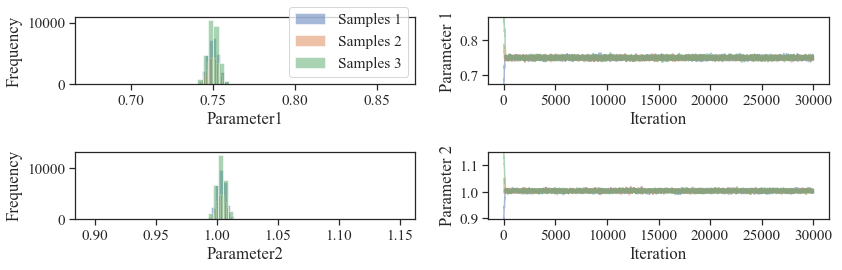

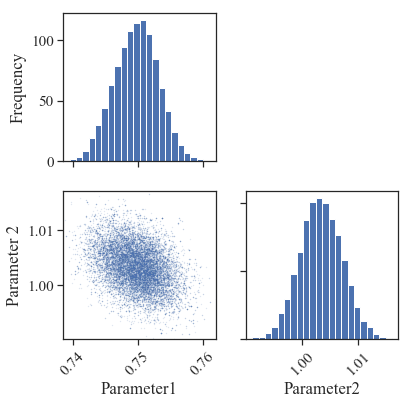

In [47]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
#sigma0 = [0.01, 0.01] #np.abs(true_parameters) * 5e-5
sigma0 = [[ 1.01547594e-05, -2.58358260e-06], [-2.58358260e-06,  1.22093040e-05]]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()

In [48]:
# Revert scaling
scaling_factors = [1/50, 500]
emulated_chains_rescaled = np.copy(emulated_chains)
emulated_chain_rescaled = emulated_chains_rescaled[0]
emulated_chain_rescaled = emulated_chain_rescaled[10000:]
emulated_chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in emulated_chains])

metropolis_chains_rescaled = np.copy(metropolis_chains)
metropolis_chain_rescaled = metropolis_chains_rescaled[0]
metropolis_chain_rescaled = metropolis_chain_rescaled[10000:]
metropolis_chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in metropolis_chains])

emulated_chain = emulated_chains[0]
emulated_chain = emulated_chain[10000:]
metropolis_chain = metropolis_chains[0]
metropolis_chain = metropolis_chain[10000:]

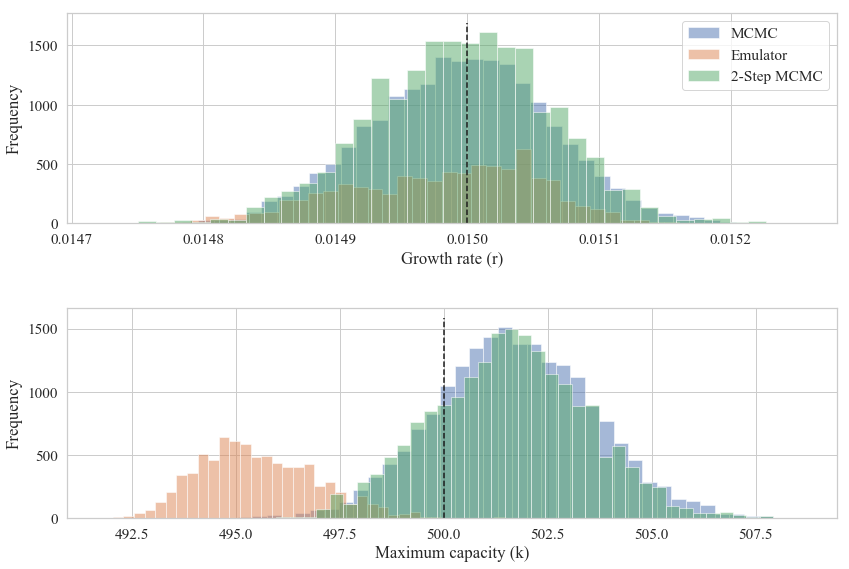

In [49]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.4, color_codes=True, rc={"grid.linewidth": 1})

fig, axes = pints.plot.histogram([metropolis_chain, chain_emu, emulated_chain], 
                                ref_parameters=true_parameters, 
                                sample_names=["MCMC", "Emulator", "2-Step MCMC"],
                                parameter_names=["Growth rate (r)", "Maximum capacity (k)"])
#axes[0].set_title('Comparison of log-posterior sample distributions\n', fontsize=16)
fig.set_size_inches(14, 10)
plt.subplots_adjust(wspace=0, hspace=0.4)
plt.show()
fig.savefig("figures/log-posterior-samples.png", bbox_inches='tight', dpi=600)

## Comparing NN performance to 2-step MCMC performance

In [50]:
from scipy import stats

metropolis_chain_r = np.array([sample[0] for sample in metropolis_chain])
metropolis_chain_k = np.array([sample[1] for sample in metropolis_chain])
chain_emu_r = np.array([sample[0] for sample in chain_emu])
chain_emu_k = np.array([sample[1] for sample in chain_emu])
emulated_chain_r = np.array([sample[0] for sample in emulated_chain])
emulated_chain_k = np.array([sample[1] for sample in emulated_chain])

w_distance1_r = stats.wasserstein_distance(metropolis_chain_r, chain_emu_r)
w_distance1_k = stats.wasserstein_distance(metropolis_chain_k, chain_emu_k)
w_distance2_r = stats.wasserstein_distance(metropolis_chain_r, emulated_chain_r)
w_distance2_k = stats.wasserstein_distance(metropolis_chain_k, emulated_chain_k)

print("NN vs MCMC:", w_distance1_r, w_distance1_k)
print("2-step MCMC vs MCMC:", w_distance2_r, w_distance2_k)

NN vs MCMC: 1.5600009826891806e-05 6.148660271518844
2-step MCMC vs MCMC: 1.2474455026703264e-06 0.14205682626618737


In [53]:
chain_emu.shape

(8000, 2)

In [54]:
metropolis_chain.shape

(20000, 2)